In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from math import fmod
import seaborn as sns
from sklearn import tree, datasets, model_selection
from sklearn.model_selection import cross_val_score
import graphviz
import os
from mpl_toolkits.mplot3d import Axes3D

In [2]:
############################################################################
#                Data Generation
############################################################################

def rand_gauss(n=100, mu=[1, 1], sigma=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigma + mu)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigma1=[0.1, 0.1],
                  sigma2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with std deviation sigma1, sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigma1)
    ex2 = rand_gauss(n2, mu2, sigma2)
    res = np.vstack([np.hstack([ex1, 1. * np.ones((n1, 1))]),
                     np.hstack([ex2, 2. * np.ones((n2, 1))])])
    ind = np.arange(res.shape[0])
    np.random.shuffle(ind)
    return np.array(res[ind, :])


def rand_tri_gauss(n1=100, n2=100, n3=100, mu1=[1, 1],
                   mu2=[-1, -1], mu3=[1, -1], sigma1=[0.1, 0.1],
                   sigma2=[0.1, 0.1], sigma3=[0.1, 0.1]):
    """ Sample n1, n2 and n3 points from three Gaussian variables centered in mu1,
    mu2 and mu3 with std deviation sigma1, sigma2 and sigma3
    """
    ex1 = rand_gauss(n1, mu1, sigma1)
    ex2 = rand_gauss(n2, mu2, sigma2)
    ex3 = rand_gauss(n3, mu3, sigma3)
    res = np.vstack([np.hstack([ex1, 1. * np.ones((n1, 1))]),
                     np.hstack([ex2, 2. * np.ones((n2, 1))]),
                     np.hstack([ex3, 3. * np.ones((n3, 1))])])
    ind = np.arange(res.shape[0])
    np.random.shuffle(ind)
    return np.array(res[ind, :])


def rand_clown(n1=100, n2=100, sigma1=1, sigma2=2):
    """ Sample a dataset clown  with
    n1 points and noise std deviation sigma1 for the first class, and
    n2 points and noise std deviation sigma2 for the second one
    """
    x0 = np.random.randn(n1)
    x1 = x0 * x0 + sigma1 * np.random.randn(n1)
    x2 = np.vstack([sigma2 * np.random.randn(n2),
                    sigma2 * np.random.randn(n2) + 2.])
    res = np.hstack([np.vstack([[x0, x1], 1. * np.ones([1, n1])]),
                     np.vstack([x2, 2. * np.ones([1, n2])])]).T
    ind = np.arange(res.shape[0])
    np.random.shuffle(ind)
    return np.array(res[ind, :])


def rand_checkers(n1=100, n2=100, n3=100, n4=100, sigma=0.1):
    """ Sample n1 and n2 points from a noisy checker"""
    nb1 = n1 // 8
    nb2 = n2 // 8
    nb3 = n3 // 8
    nb4 = n4 // 8

    xapp = np.reshape(np.zeros((nb1 + nb2 + nb3 + nb4) * 16),
                      [(nb1 + nb2 + nb3 + nb4) * 8, 2])
    yapp = np.ones((nb1 + nb2 + nb3 + nb4) * 8)
    idx = 0
    nb = 2 * nb1
    for i in range(-2, 2):
        for j in range(-2, 2):
            yapp[idx:(idx + nb)] = [fmod(i - j + 100, 4)] * nb
            xapp[idx:(idx + nb), 0] = np.random.rand(nb)
            xapp[idx:(idx + nb), 0] += i + sigma * np.random.randn(nb)
            xapp[idx:(idx + nb), 1] = np.random.rand(nb)
            xapp[idx:(idx + nb), 1] += j + sigma * np.random.randn(nb)
            idx += nb

    ind = np.arange((nb1 + nb2 + nb3 + nb4) * 8)
    np.random.shuffle(ind)
    res = np.hstack([xapp, yapp[:, np.newaxis]])
    return np.array(res[ind, :])


In [4]:


############################################################################
#            Displaying labeled data
############################################################################
symlist = ['o', 's', 'D', 'x', '+', '*', 'p', 'v', '-', '^']


def plot_2d(data, y=None, w=None, alpha_choice=1):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    if y is None:
        labs = [""]
        idxbyclass = [range(data.shape[0])]
    else:
        labs = np.unique(y)
        idxbyclass = [np.where(y == labs[i])[0] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.scatter(data[idxbyclass[i], 0], data[idxbyclass[i], 1],
                    c=color_blind_list[i], s=80, marker=symlist[i])
    plt.ylim([np.min(data[:, 1]), np.max(data[:, 1])])
    plt.xlim([np.min(data[:, 0]), np.max(data[:, 0])])
    mx = np.min(data[:, 0])
    maxx = np.max(data[:, 0])
    if w is not None:
        plt.plot([mx, maxx], [mx * -w[1] / w[2] - w[0] / w[2],
                              maxx * -w[1] / w[2] - w[0] / w[2]],
                 "g", alpha=alpha_choice)


def plot_2d_simple(data, y=None):
    if y is None:
        plt.scatter(data[:, 0], data[:, 1], s=50)
    else:
        nY = len(y)
        y = y.astype(int)
        Ycol = [collist[y[i] - 1 % len(collist)] for i in range(nY)]
        plt.scatter(data[:, 0], data[:, 1], c=Ycol, s=40)

### Question 1

In [6]:
n1=25
n2=25
mu1=[0, 0]
mu2=[0, 0]
sigma1=[1, 1]
sigma2=[1, 4]

data1 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

In [10]:
n1=25
n2=25
mu1=[2, 2]
mu2=[2, 2]
sigma1=[1, 1]
sigma2=[1, 4]

data2 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

In [13]:
n1=25
n2=25
mu1=[2, 2]
mu2=[2, 2]
sigma1=[4, 4]
sigma2=[4, 16]

data3 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

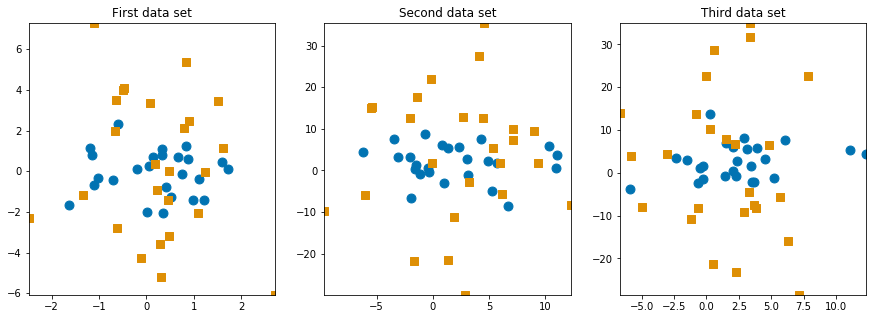

In [15]:
plt.close("all")
plt.ion()
plt.figure(1, figsize=(15, 5))
plt.subplot(131)
plt.title('First data set')
plot_2d(data1[:, :2], data1[:, 2], w=None)
plt.subplot(132)
plt.title('Second data set')
plot_2d(data2[:, :2], data2[:, 2], w=None)
plt.subplot(133)
plt.title('Third data set')
plot_2d(data3[:, :2], data3[:, 2], w=None)

### Question 2 (Mahalanobis)

In [36]:
def depthMah(data):
    mean_data = data.mean()
    V = np.cov(data.T)
    VI = np.linalg.inv(V)
    data_mahalanobis = np.diag(np.sqrt(np.dot(np.dot((data - mean_data),VI),(data- mean_data).T)))
    depth_mahalanobis = 1 / (1 + data_mahalanobis)
    return depth_mahalanobis

In [37]:
data1_depthmahalanobis = depthMah(data1)
data1_depthmahalanobis

/home/parfait/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


array([0.32586438, 0.23340123, 0.18006454, 0.25180856, 0.26112514,
       0.18842334, 0.26123243, 0.20953661, 0.44098586, 0.24416663,
       0.45522683, 0.2010275 , 0.25221894, 0.53965838, 0.49413791,
       0.2341487 , 0.24638368, 0.51676728, 0.43869657, 0.39428699,
       0.49748225, 0.26995479, 0.21656131, 0.33722941, 0.34173396,
       0.23886207, 0.22849516, 0.25355256, 0.23954902, 0.25229228,
       0.41773011, 0.33539403, 0.45521675, 0.37262317, 0.25888266,
       0.53701093, 0.53817729, 0.49012712, 0.46673155, 0.25788977,
       0.55186578, 0.24318197, 0.22258775, 0.53126193, 0.25992519,
       0.39670331, 0.41428838, 0.53437196, 0.21569328, 0.2392436 ])

In [38]:
data2_depthmahalanobis = depthMah(data2)
data2_depthmahalanobis

/home/parfait/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


array([0.30688786, 0.30982482, 0.26099864, 0.43836172, 0.48295738,
       0.31205252, 0.50448293, 0.30348107, 0.3118633 , 0.25821058,
       0.4009188 , 0.39197933, 0.30554673, 0.46693033, 0.35903297,
       0.67180996, 0.27923876, 0.30068742, 0.44288719, 0.2839956 ,
       0.30613984, 0.31192001, 0.3113196 , 0.25645019, 0.30402161,
       0.4799926 , 0.30945647, 0.26663455, 0.33972778, 0.30859094,
       0.56816915, 0.29949173, 0.29985102, 0.25069478, 0.29572427,
       0.38702125, 0.29257404, 0.35274678, 0.3040971 , 0.32637932,
       0.5497974 , 0.29960131, 0.26238078, 0.33910177, 0.30885202,
       0.29626799, 0.66066687, 0.30495468, 0.28428767, 0.46172489])

In [39]:
data3_depthmahalanobis = depthMah(data3)
data3_depthmahalanobis

/home/parfait/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


array([0.31695283, 0.29125005, 0.31976466, 0.61629877, 0.538351  ,
       0.33915131, 0.33652322, 0.3384215 , 0.24139582, 0.46417437,
       0.34344802, 0.31536092, 0.47899991, 0.33147546, 0.55996795,
       0.32154479, 0.35620812, 0.34378676, 0.31104241, 0.34177648,
       0.4321712 , 0.24672054, 0.36786352, 0.67233174, 0.3251486 ,
       0.34200189, 0.27078354, 0.53319002, 0.34217094, 0.29069831,
       0.51546109, 0.71097295, 0.29784203, 0.3288622 , 0.33965295,
       0.33744198, 0.32225902, 0.34149024, 0.33138471, 0.52002606,
       0.33965364, 0.46036957, 0.33096378, 0.25647719, 0.34033457,
       0.42603792, 0.30091382, 0.2655716 , 0.33796942, 0.30995281])

In [40]:
data3_depthmahalanobis.shape

(50,)

In [46]:
test = data1_depthmahalanobis.reshape((-1,1))
test.shape

(50, 1)

ValueError: x and y must be the same size

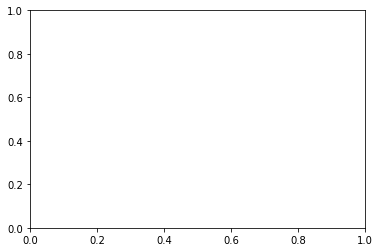

In [49]:
plt.scatter(data1[:, :2], data1[:, 2])
plt.show()

### Question 3